In [1]:
#80:20
#IMPORTING THE DATA

DATASET_DIR = './kaggle-dataset/'
GLOVE_DIR = './glove.6B/'
SAVE_DIR = './'

import os
import pandas as pd

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])

In [2]:
targ = X['domain1_score']
targ

0         8
1         9
2         7
3        10
4         8
5         8
6        10
7        10
8         9
9         9
10        8
11        8
12        7
13        6
14        6
15       12
16        8
17        8
18        4
19        6
20        8
21        3
22       10
23       11
24        8
25        9
26        4
27        9
28        9
29        8
         ..
12946    40
12947    32
12948    36
12949    31
12950    30
12951    47
12952    40
12953    35
12954    33
12955    36
12956    36
12957    48
12958    40
12959    40
12960    40
12961    42
12962    40
12963    32
12964    36
12965    40
12966    10
12967    33
12968    44
12969    35
12970    30
12971    35
12972    32
12973    40
12974    40
12975    40
Name: domain1_score, Length: 12976, dtype: int64

In [3]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.2))
    model.add(Dense(1, activation='relu'))
    model.add(Dropout(0.2))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','mse'])
    model.summary()

    return model

C:\Users\PARIDHI\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PARIDHI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

In [6]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import math
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, targ, test_size=0.2, random_state=1)  
train_essays = X_train['essay']
test_essays = X_test['essay']
print(test_essays)
print(train_essays)
sentences = []

C:\Users\PARIDHI\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


3289     Do I think that certain materials that are off...
4395     The setting affect the cyclist because it crea...
5864     Emotion, camitmint, hope, all are reasons why ...
6466     Its the start of a new life. She has a new new...
6943     The author concludes the story with the senten...
4883     In the book Do Not Exceed Posted Speed Limit...
4744     In the cyclists journey to Yosemite, several f...
10814    One day I was at home and I was getting ready ...
3989     The features in the setting dramaticaly affect...
223      @ORGANIZATION1, Computers have great effects t...
724      Dear Newspaper, I think that the effects are o...
1804     I think that books, magazines, papers etc shou...
12500                                      Friendship a...
5255     There are many things that could affect affect...
12764    It was @NUM1 pm. at night i was watchin @CAPS1...
335      Dear Local newspaper, @CAPS1 well @CAPS1 many ...
8897     The builders of the Empire State Building face.

In [7]:
for essay in train_essays:
            # Obtaining all sentences from the training essays.
    sentences += essay_to_sentences(essay, remove_stopwords = True)
            
    # Initializing variables for word2vec model.
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec Model...")
model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

# model.init_sims(replace=True)
#     model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

clean_train_essays = []
    
    # Generate training and testing data word vectors.
for essay_v in train_essays:
    clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
    
clean_test_essays = []
for essay_v in test_essays:
    clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
trainDataVecs = np.array(trainDataVecs)
testDataVecs = np.array(testDataVecs)
    
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))


Training Word2Vec Model...


C:\Users\PARIDHI\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [8]:
lstm_model = get_model()
history = lstm_model.fit(trainDataVecs, y_train, batch_size=32, epochs=120, validation_split=0.33, verbose=1)
lstm_model.reset_states()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Train on 6954 samples, validate on 3426 samples
Epoch 1/120
6954/6954 [==============================] - 41s 6ms/step - loss: 56.0773 - mean_absolute_error: 3.8695 - mean_squared_error: 56.0773 - val_loss: 32.0906 - val_mean_absolute_error: 2.6281 - val_mean_squared_e

6954/6954 [==============================] - 19s 3ms/step - loss: 24.5351 - mean_absolute_error: 2.0043 - mean_squared_error: 24.5351 - val_loss: 8.6932 - val_mean_absolute_error: 1.5668 - val_mean_squared_error: 8.6932olute_error: 2.
Epoch 65/120
6954/6954 [==============================] - 21s 3ms/step - loss: 25.9846 - mean_absolute_error: 2.0246 - mean_squared_error: 25.9846 - val_loss: 8.8630 - val_mean_absolute_error: 1.6357 - val_mean_squared_error: 8.8630
Epoch 66/120
6954/6954 [==============================] - 23s 3ms/step - loss: 27.0337 - mean_absolute_error: 2.0662 - mean_squared_error: 27.0337 - val_loss: 9.4045 - val_mean_absolute_error: 1.6400 - val_mean_squared_error: 9.4045
Epoch 67/120
6954/6954 [==============================] - 22s 3ms/step - loss: 26.1167 - mean_absolute_error: 2.0555 - mean_squared_error: 26.1167 - val_loss: 7.9535 - val_mean_absolute_error: 1.5811 - val_mean_squared_error: 7.9535
Epoch 68/120
6954/6954 [==============================] - 20s 3ms/

        Actual              Predicted
0       4                   3
1       2                   1
2       2                   1
3       1                   1
4       2                   1
5       1                   0
6       2                   2
7       17                  13
8       2                   2
9       8                   7
10      6                   6
11      3                   3
12      40                  30
13      1                   1
14      28                  18
15      10                  8
16      3                   2
17      1                   2
18      7                   6
19      12                  8
20      3                   2
21      1                   0
22      4                   3
23      3                   2
24      7                   16
25      1                   1
26      3                   3
27      30                  24
28      8                   7
29      3                   2
30      3                   2
31      4                  

1261    8                   6
1262    17                  9
1263    1                   1
1264    4                   2
1265    0                   0
1266    2                   2
1267    2                   1
1268    1                   1
1269    11                  8
1270    39                  28
1271    0                   1
1272    1                   2
1273    3                   2
1274    12                  9
1275    1                   2
1276    2                   1
1277    0                   0
1278    2                   1
1279    8                   7
1280    10                  8
1281    1                   1
1282    0                   0
1283    1                   1
1284    2                   1
1285    3                   2
1286    15                  14
1287    2                   2
1288    17                  15
1289    2                   2
1290    3                   2
1291    9                   7
1292    4                   2
1293    15                  15
1294  

1760    17                  11
1761    1                   1
1762    3                   2
1763    3                   2
1764    8                   7
1765    4                   3
1766    40                  31
1767    6                   6
1768    3                   2
1769    2                   2
1770    3                   2
1771    20                  14
1772    1                   1
1773    22                  19
1774    1                   1
1775    4                   4
1776    15                  11
1777    4                   3
1778    4                   3
1779    2                   1
1780    3                   3
1781    4                   3
1782    1                   1
1783    2                   2
1784    3                   3
1785    3                   3
1786    10                  7
1787    26                  10
1788    3                   2
1789    2                   2
1790    4                   3
1791    0                   1
1792    50                  32
179

2260    3                   2
2261    3                   2
2262    2                   2
2263    2                   1
2264    2                   1
2265    2                   2
2266    4                   3
2267    1                   2
2268    4                   3
2269    7                   6
2270    8                   7
2271    2                   2
2272    3                   3
2273    4                   2
2274    28                  23
2275    4                   3
2276    3                   3
2277    3                   2
2278    7                   6
2279    4                   3
2280    0                   0
2281    2                   2
2282    10                  7
2283    2                   1
2284    3                   3
2285    4                   3
2286    10                  7
2287    1                   0
2288    8                   7
2289    3                   3
2290    16                  10
2291    8                   8
2292    8                   6
2293    

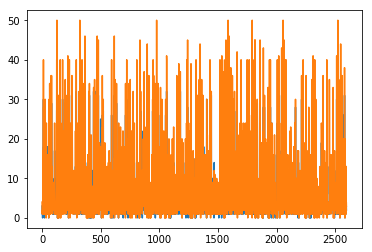

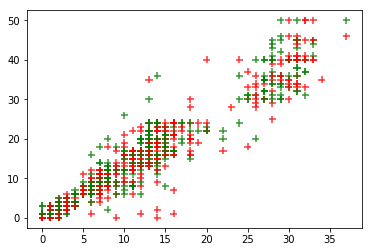

In [17]:
test = lstm_model.predict(testDataVecs)
test = np.around(test).astype(int)
flat_test = []
for sublist in test:
    for item in sublist:
        flat_test.append(item)

flat_actual = []
for item in y_test:
    flat_actual.append(item)

fmt = '{:<8}{:<20}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (name, grade) in enumerate(zip(flat_actual, flat_test)):
    print(fmt.format(i, name, grade))

plt.plot(flat_test)
plt.plot(flat_actual)
plt.show()


plt.scatter(flat_test,flat_actual,marker="+",s=50,alpha=0.8,c=['r','g'],cmap='viridis')
plt.show()



In [19]:
result = cohen_kappa_score(y_test.values,test,weights='quadratic')
print("Kappa Score: {}".format(result))

Kappa Score: 0.9235968366963003


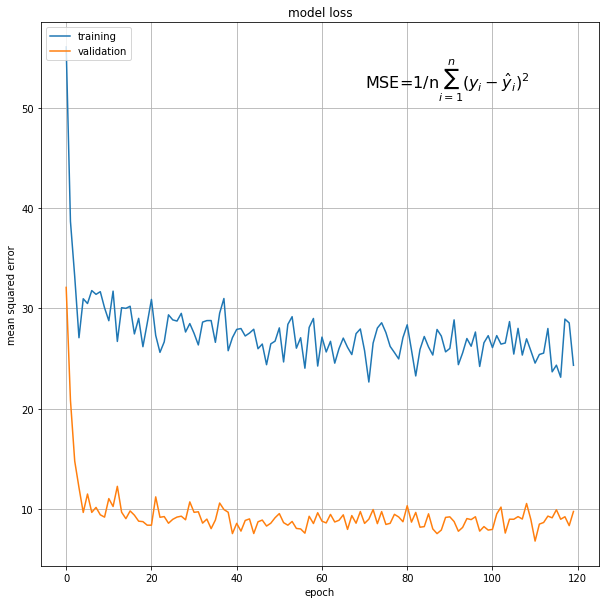

In [18]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,10))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model loss')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.text(70,52, r'MSE=1/n$\sum_{i=1}^n (y_i-\^y_i)^2$',
         fontsize=16)
plt.grid(True)
plt.show()